# Project Description

The goal of the project is given a dataset that includes information about online purchases of users in an online-shop to predict whether or not the user will purchase a beverage in the next order. 

Our task is therefore to perform binary classification (since we are talking about 2 classes) and make predictions  by extracting features from the dataset and choosing the appropriate model.

# Data Analysis and Feature Extraction 

In order to extract features for our model we first need to explore the dataset and consider habits of the users described.

In [68]:
from __future__ import division
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#read train test data
X_train=pd.read_csv("data/X_train.csv")
y_train=pd.read_csv("data/y_train.csv")
y_train.drop('order_id', axis=1, inplace=True)


In [3]:
orders = pd.read_csv('data/orders.csv')
products = pd.read_csv('data/products.csv')
orders_priors = pd.read_csv('data/order_products__prior.csv')
departments = pd.read_csv('data/departments.csv')
aisles = pd.read_csv('data/aisles.csv')

In [4]:
# number of aisles and departments
num_aisles= aisles.aisle_id.nunique()
num_deps = departments.department_id.nunique()


# Feature Extraction

In [5]:
# convert categorical data to dummy values
X_train = X_train.drop(['order_dow', 'order_hour_of_day'], axis=1)
#X_train= pd.get_dummies(X_train, prefix=["d", "h"], columns=['order_dow', 'order_hour_of_day'])
X_train.head(2)

,order_id,user_id,order_number,days_since_prior_order
0,3110915,94104,58,2.0
1,2277131,18463,4,24.0


## Beverages

In [6]:
# products in department 7
products_bev = products[products['department_id']==7]
products_bev_id = list(products_bev.product_id.values)
num_aisles_7 = products_bev.aisle_id.nunique()
num_bev = products_bev.product_id.nunique()

In [7]:
#  prior orders of department 7
orders_priors_bev = orders_priors[orders_priors['product_id'].isin(products_bev_id)]
orders_prior_id_bev = list(orders_priors_bev.order_id.values)

In [8]:
# orders of department 7
orders_bev = orders[orders['order_id'].isin(orders_prior_id_bev)]
orders_bev.head(2)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,1,2,8,NaN
1,2398795,1,2,3,7,15.0


## Orders per User

A user with many orders as well as many orders that involve beverages is more likely to purchase a beverage in the next order. Also a user with a big ratio of beverages orders over orders seems to order beverages frequently and therefore this seems to be a good feature for our model.

In [9]:
# count orders of department 7 for every user
count_ord_bev = orders_bev.groupby('user_id')['order_id'].count().reset_index()
count_ord_bev.rename(columns={'order_id':'order_count'}, inplace=True)

In [10]:
# count orders of all departments for every user
count_ord = orders.groupby('user_id')['order_id'].count().reset_index()
count_ord.rename(columns={'order_id':'orders_count'}, inplace=True)

In [11]:
count_ord_bev = count_ord_bev.merge(count_ord, on='user_id', how='left')

In [12]:
# calculate ratio of orders with beverages to orders of all deps
count_ord_bev['orders_bev_ratio']= count_ord_bev['order_count']/count_ord_bev['orders_count']
count_ord_bev.head(2)

,user_id,order_count,orders_count,orders_bev_ratio
0,1,10,11,0.909091
1,2,6,15,0.400000


In [13]:
# feature 2 bev_orders/orders per user
X_train = X_train.merge(count_ord_bev[['user_id', 'orders_bev_ratio']], on='user_id', how='left')
X_train = X_train.fillna(0.0)

In [14]:
# feature 3 beverages orders per user
X_train = X_train.merge(count_ord_bev[['user_id', 'order_count']], on='user_id', how='left')
X_train = X_train.fillna(0.0)

In [15]:
# feature 4 orders per user
X_train = X_train.merge(count_ord_bev[['user_id', 'orders_count']], on='user_id', how='left')
X_train = X_train.fillna(0.0)

## Beverages per basket per user

If a user has a big ratio of beverages per basket this seems to be a good indicator that he is more likely to purchase a beverage in his next order. The same applies for a user with a high average of beverages. 

In [16]:
# calculate size of each order
orders_priors['size_of_order']=orders_priors.groupby('order_id')['add_to_cart_order'].transform('max')

In [17]:
# add size of basket 
orders_priors_bev = orders_priors_bev.merge(orders_priors[['order_id', 'size_of_order']].drop_duplicates(subset=['order_id']), on='order_id', how='left')
orders_bev = orders_bev.merge(orders_priors_bev[['order_id', 'size_of_order']].drop_duplicates(subset=['order_id']), on='order_id', how='left')
orders_bev.head(3)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,size_of_order
0,2539329,1,1,2,8,NaN,5
1,2398795,1,2,3,7,15.0,6
2,473747,1,3,3,12,21.0,5


In [18]:
# calculate total beverages count per order
beverages_count= orders_priors_bev.groupby('order_id')['product_id'].count().reset_index()
beverages_count = beverages_count.rename(columns={'product_id':'beverages_count'})

In [19]:
orders_priors_bev = orders_priors_bev.merge(beverages_count, on='order_id', how='left')
orders_bev = orders_bev.merge(beverages_count, on='order_id', how='left')

In [20]:
# calculate beverages per basket
orders_priors_bev['bev_per_basket']= np.where(orders_priors_bev['beverages_count'] < 1, orders_priors_bev['beverages_count'], orders_priors_bev['beverages_count']/orders_priors_bev['size_of_order'])


In [21]:
orders_bev = orders_bev.merge(orders_priors_bev[['order_id', 'bev_per_basket']].drop_duplicates(subset=['order_id']), on='order_id', how='left')

In [22]:
# average beverage per basket per user
bev_per_basket = orders_bev.groupby('user_id')['bev_per_basket'].mean().reset_index()

In [23]:
# feature 5 average beverage per basket per user
X_train = X_train.merge(bev_per_basket, on='user_id', how='left')
X_train  = X_train.fillna(0.0)

In [24]:
# mean beverages count per user
beverages = orders_bev.groupby('user_id')['beverages_count'].mean().reset_index()
beverages = beverages.rename(columns={'beverages_count':'mean_beverage_count'})

In [25]:
# feature 6 mean beverages count per user
X_train = X_train.merge(beverages, on='user_id', how='left')
X_train  = X_train.fillna(0.0)

In [26]:
orders = orders.merge(count_ord, on='user_id', how='left')

In [27]:
orders_bev = orders_bev.merge(count_ord_bev, on='user_id', how='left')

## Size of Order

In [28]:
# feature 7 size of order
X_train = X_train.merge(orders_bev[['user_id','size_of_order' ]].drop_duplicates(subset=['user_id']), on='user_id', how='left')
X_train  = X_train.fillna(0.0)

## Reordered beverages per user

The ratio of reordered beverages per user shows how frequently the user prefers the same beverages and tends to rebuy them which is a good predictor. In this basis we can consider certain features to add to our model. Other than the average of reordered beverages per user, we can consider the reorder beverages per basket meaning how many of the products in an order are reordered beverages at a time. 

In [29]:
# count how many of the beverages are reordered by order_id
reordered_beverages = orders_priors_bev.groupby('order_id')['reordered'].sum().reset_index()
reordered_beverages = reordered_beverages.rename(columns={'reordered':'reordered_bev_count'})

In [30]:
orders_bev = orders_bev.merge(reordered_beverages, on='order_id', how='left')

In [31]:
# calculate beverage reorder ratio for every order
orders_bev['reorder_bev_ratio']= orders_bev['reordered_bev_count']/orders_bev['beverages_count']
orders_bev['reorder_bev_basket_rt']=orders_bev['reordered_bev_count']/orders_bev['size_of_order']
orders_bev.head(2)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,size_of_order,beverages_count,bev_per_basket,order_count,orders_count,orders_bev_ratio,reordered_bev_count,reorder_bev_ratio,reorder_bev_basket_rt
0,2539329,1,1,2,8,NaN,5,1,0.200000,10,11,0.909091,0,0.0,0.000000
1,2398795,1,2,3,7,15.0,6,1,0.166667,10,11,0.909091,1,1.0,0.166667


In [32]:
# calculate user average ratio of beverages that are reordered
user_reorder_bev_ratio = orders_bev.groupby('user_id')['reordered_bev_count'].mean().reset_index()
user_reorder_bev_ratio = user_reorder_bev_ratio.rename(columns={'reordered_bev_count':'user_bev_reorder_rt'})

In [33]:
# calculate user average ratio of bev per basket that are reordered
user_reorder_bev_basket_rt = orders_bev.groupby('user_id')['reorder_bev_basket_rt'].mean().reset_index()
user_reorder_bev_basket_rt = user_reorder_bev_basket_rt.rename(columns={'reorder_bev_basket_rt':'user_bev_basket_reorder_rt'})

In [34]:
orders_bev = orders_bev.merge(user_reorder_bev_ratio[['user_id', 'user_bev_reorder_rt']], on='user_id', how='left')
orders_bev = orders_bev.merge(user_reorder_bev_basket_rt[['user_id', 'user_bev_basket_reorder_rt']], on='user_id', how='left')

In [35]:
# feature 8 user average ratio of beverages that are reordered
X_train = X_train.merge(user_reorder_bev_ratio, on='user_id', how='left')
X_train = X_train.fillna(0.0)

In [36]:
# feature 9 user average ratio of bev per basket that are reordered
X_train = X_train.merge(user_reorder_bev_basket_rt, on='user_id', how='left')
X_train = X_train.fillna(0.0)

## Product Reorder per user

Relative to the ratio of beverages that are reordered by user this feature, the ratio of products that are reordered per user also shows a measure of habbit

In [37]:
# count how many of the products are reordered by order_id
reordered_prod = orders_priors.groupby('order_id')['reordered'].sum().reset_index()
reordered_prod = reordered_prod.rename(columns={'reordered':'reordered_prod_count'})

In [38]:
product_count= orders_priors.groupby('order_id')['product_id'].count().reset_index()
product_count = product_count.rename(columns={'product_id':'product_count'})
orders = orders.merge(product_count, on='order_id', how='left')

In [39]:
orders = orders.merge(reordered_prod, on='order_id', how='left')

In [40]:
orders['reorder_ratio_all']= np.where(orders['reordered_prod_count']<1, orders['reordered_prod_count'], orders['reordered_prod_count']/orders['product_count'])

In [41]:
orders_bev = orders_bev.merge(orders[['order_id', 'reordered_prod_count', 'reorder_ratio_all']].drop_duplicates(subset=['order_id']), on='order_id', how='left')

In [42]:
user_reorder_ratio = orders_bev.groupby('user_id')['reordered_prod_count'].mean().reset_index()
user_reorder_ratio = user_reorder_ratio.rename(columns={'reordered_prod_count':'user_prod_reorder_rt'})

In [43]:
orders_bev = orders_bev.merge(user_reorder_ratio[['user_id', 'user_prod_reorder_rt']], on='user_id', how='left')

In [44]:
# feature 10 average user product reorder ratio 
X_train = X_train.merge(user_reorder_ratio, on='user_id', how='left')
X_train = X_train.fillna(0.0)

## Average interval between days 

The frequency in days the user purchases beverages and products as well as the ratio between those seems to provide information about the user's behaviour

In [45]:
# average interval between buying beverages per user
average_order_days_bev = orders_bev.groupby('user_id')['days_since_prior_order'].mean().reset_index()
average_order_days_bev = average_order_days_bev.rename(columns={'days_since_prior_order':'avg_bev_days_since_prior'})

In [46]:
# average interval between buying products per user
avg_order_days = orders.groupby('user_id')['days_since_prior_order'].mean().reset_index()
avg_order_days = avg_order_days.rename(columns={'days_since_prior_order':'avg_days_since_prior'})

In [47]:
average_order_days_bev = average_order_days_bev.merge(avg_order_days, on='user_id', how='left')

In [48]:
# average interval ratio bev/prod
average_order_days_bev['avg_days_bev']=average_order_days_bev['avg_bev_days_since_prior']/average_order_days_bev['avg_days_since_prior']

In [49]:
# feature 11 average interval ratio bev/prod
X_train = X_train.merge(average_order_days_bev[['user_id', 'avg_days_bev']], on='user_id', how='left')
X_train = X_train.fillna(0.0)

In [50]:
# feature 12 average interval between buying products per user
X_train = X_train.merge(average_order_days_bev[['user_id', 'avg_days_since_prior']], on='user_id', how='left')
X_train = X_train.fillna(0.0)

## Reorder mean per days since prior

Relative to the previous feature, this feature aims to give us information on whether there is a relationship between the days that have passed since the prior order and the reordered ratio of products.

In [51]:
# calculate average mean reorder per days since prior order
orders_prod_days = orders_bev.merge(orders_priors_bev, on='order_id', how='left')
grouped_days_df = orders_prod_days.groupby('days_since_prior_order')['reordered'].mean().reset_index()
grouped_days_df = grouped_days_df.rename(columns={'reordered':'days_reorder'})

In [52]:
orders_bev = orders_bev.merge(grouped_days_df, on='days_since_prior_order', how='left')

In [53]:
# user average mean reorder per days since prior order
user_days_reorder = orders_bev.groupby('user_id')['days_reorder'].mean().reset_index()
user_days_reorder = user_days_reorder.rename(columns={'days_reorder':'user_days_reorder'})

In [54]:
# feature 13 user average mean reorder per days since prior order
X_train = X_train.merge(user_days_reorder, on='user_id', how='left')
X_train = X_train.fillna(0.0)

## Department Ratio


The department ratio indicates whether the user shops from many departments in each order he places. If he does that makes him more likely to include beverages in his next order. 

In [55]:
# create department columns in prior orders frame
orders_priors = orders_priors.merge(products[['product_id', 'department_id']], on = 'product_id', how='left')
unique_deps = orders_priors.groupby('order_id')['department_id'].nunique().reset_index()
unique_deps = unique_deps.rename(columns={'department_id':'unique_deps'})
orders_priors = orders_priors.merge(unique_deps, on='order_id', how='left')

In [56]:
# calculate the ratio of how many departments did the user shop from in relation to total departments per order
orders_priors['department_ratio']= orders_priors['unique_deps']/num_deps


In [57]:
orders_priors_bev = orders_priors_bev.merge(orders_priors[['order_id', 'department_ratio']].drop_duplicates(subset=['order_id']), on='order_id', how='left')
orders_bev = orders_bev.merge(orders_priors_bev[['order_id','department_ratio']].drop_duplicates(subset=['order_id']), on='order_id', how='left')

In [58]:
# calculate average user department ratio
user_department_ratio = orders_bev.groupby('user_id')['department_ratio'].mean().reset_index()
user_department_ratio = user_department_ratio.rename(columns={'department_ratio':'user_department_ratio'})

In [59]:
# feature14 average user department ratio
X_train = X_train.merge(user_department_ratio, on='user_id', how='left')
X_train = X_train.fillna(0.0)

## Aisles Ratio

Aisles ratio is also a measure that indicates variety since the more aisles the user roams in every order the more likely he is to have a wide range of products in his basket.

In [60]:
# create aisles columns in prior orders frame
orders_priors = orders_priors.merge(products[['product_id', 'aisle_id']], on='product_id', how='left')
unique_aisles = orders_priors.groupby('order_id')['aisle_id'].nunique().reset_index()
unique_aisles = unique_aisles.rename(columns={'aisle_id':'unique_aisles'})
orders_priors = orders_priors.merge(unique_aisles, on='order_id', how='left')

In [61]:
# calculate the ratio of how many aisles did the user shop from in relation to total aisles per order
orders_priors_bev = orders_priors_bev.merge(products[['product_id', 'aisle_id']], on='product_id', how='left')

In [62]:
# calculate the ratio of how many aisles did the user shop from in relation to total aisles per order
orders_priors['aisles_ratio']= orders_priors['unique_aisles']/num_aisles

In [63]:
# calculate average user aisle ratio
orders_priors_bev = orders_priors_bev.merge(orders_priors[['order_id','aisles_ratio']].drop_duplicates(subset=['order_id']), on='order_id', how='left')
orders_bev = orders_bev.merge(orders_priors_bev[['order_id','aisles_ratio']].drop_duplicates(subset=['order_id']), on='order_id', how='left')
user_aisles_ratio = orders_bev.groupby('user_id')['aisles_ratio'].mean().reset_index()
user_aisles_ratio = user_aisles_ratio.rename(columns={'aisles_ratio':'user_aisles_ratio'})

In [64]:
# feature 15 average user aisle ratio
X_train = X_train.merge(user_aisles_ratio, on='user_id', how='left')
X_train = X_train.fillna(0.0)

## Add to cart early per user

We now consider the relation between the order in which the user places a product in the cart with the possibility that this product is reordered. To do so, we can plot the average reorder ratio per add to cart order.

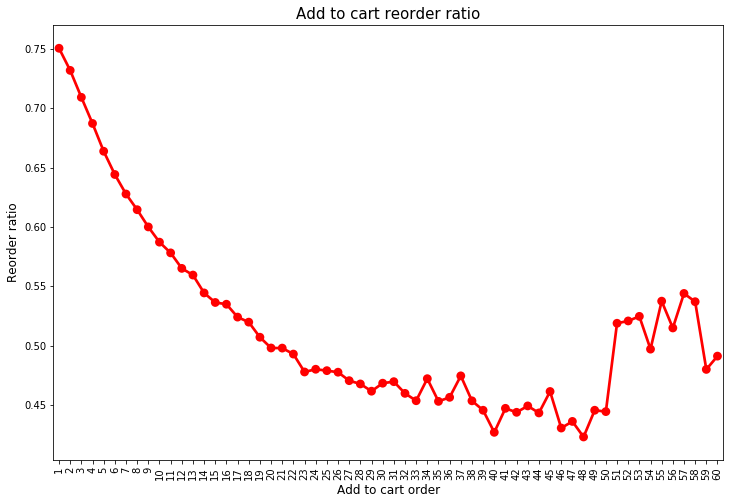

In [69]:
reorder_add = orders_priors_bev.copy()
reorder_add['add_to_cart_order'] = np.where(reorder_add['add_to_cart_order']>60, 60, reorder_add['add_to_cart_order'])

grouped_df = reorder_add.groupby(["add_to_cart_order"])["reordered"].aggregate("mean").reset_index()
plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order'].values, grouped_df['reordered'].values, alpha=0.5, color='red')
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)

plt.title("Add to cart reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.savefig('Add to cart reorder ratio.png')
plt.show()

According to the diagram there is a relation between the order the customer places beverages to the cart with the possibility of reordering them. We can assume that this is reasonably true for all the products since we are talking about an e-shop and considering that we place first the products that we usually buy whereas in a physical store the order in which we put products to the cart dependes on how the aisles are shaped.

In [70]:
# calculate average reorder per add to cart order
grouped_df = orders_priors_bev.groupby(["add_to_cart_order"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.rename(columns={'reordered':'prob_reorder_add_to_cart'})
orders_priors_bev = orders_priors_bev.merge(grouped_df, on='add_to_cart_order', how='left')

In [71]:
orders_prod_df = orders_bev.merge(orders_priors_bev, on='order_id', how='left')
prob_add = orders_prod_df.groupby('user_id')['prob_reorder_add_to_cart'].mean().reset_index()
orders_bev = orders_bev.merge(prob_add.drop_duplicates(subset=['user_id']), on='user_id', how='left')

In [72]:
user_prob_reorder_add_to_cart = orders_bev.groupby('user_id')['prob_reorder_add_to_cart'].mean().reset_index()
user_prob_reorder_add_to_cart = user_prob_reorder_add_to_cart.rename(columns={'prob_reorder_add_to_cart':'user_prob_reorder_add_to_cart'})

In [73]:
# feature 16 user average reorder per add to cart order
X_train = X_train.merge(user_prob_reorder_add_to_cart, on='user_id', how='left')
X_train = X_train.fillna(0.0)

## Unique Beverages 

How many of the beverages has the user purchased before?

In [74]:
# calculate how many of the unique beverages code the user has shopped from
orders_products_df = orders_bev.merge(orders_priors_bev, on='order_id', how='left')
bev_rt = orders_products_df.groupby('user_id')['product_id'].nunique().reset_index()
bev_rt = bev_rt.rename(columns={'product_id':'bev_unique'})
orders_bev = orders_bev.merge(bev_rt, on='user_id', how='left')
orders_bev['bev_rt']= orders_bev['bev_unique']/num_bev

In [75]:
# feature 18 unique beverages ratio
X_train = X_train.merge(orders_bev[['user_id', 'bev_rt']].drop_duplicates(subset=['user_id']), on='user_id', how='left')
X_train = X_train.fillna(0.0)

## Reorder Bev vs Reorder Prod

The ratio of reordered beverages vs reordered products can indicate the tendency of the user of reordering beverages is stronger than this of reordering other products.

In [76]:
orders_bev['bev_prod_reorder_rt']= orders_bev['reordered_bev_count']/orders_bev['reordered_prod_count']

In [77]:
# feature 19 beverages reordered versus product reordered ratio
X_train = X_train.merge(orders_bev[['user_id', 'bev_prod_reorder_rt']].drop_duplicates(subset=['user_id']), on='user_id', how='left')
X_train = X_train.fillna(0.0)

## Days 

In [78]:
# estimate in which day do the most orders appear per user
days_rt = orders_bev.groupby('user_id')['order_dow'].nunique().reset_index()
days_rt = days_rt.rename(columns={'order_dow':'shopping_days'})
orders_bev = orders_bev.merge(days_rt, on='user_id', how='left')
orders_bev['days_rt']= orders_bev['shopping_days']/7

In [79]:
# feature 20 days ratio per user
X_train = X_train.merge(orders_bev[['user_id','days_rt']].drop_duplicates(subset=['user_id']), on='user_id', how='left')
X_train = X_train.fillna(0.0)

## Hours

In [80]:
# estimate in which hour do the most orders appear per user
hours_rt = orders_bev.groupby('user_id')['order_hour_of_day'].nunique().reset_index()
hours_rt = hours_rt.rename(columns={'order_hour_of_day':'shopping_hours'})
orders_bev = orders_bev.merge(hours_rt, on='user_id', how='left')
orders_bev['hours_rt']= orders_bev['shopping_hours']/24

In [81]:
# feature 21 hours ratio per user
X_train = X_train.merge(orders_bev[['user_id','hours_rt']].drop_duplicates(subset=['user_id']), on='user_id', how='left')
X_train = X_train.fillna(0.0)

## Aisles of department 7

Calculate the ratio of from how many of the aisles of the department 7 has the user shopped from

In [82]:
orders_aisles = orders_bev.merge(orders_priors_bev[['order_id', 'aisle_id']], on='order_id', how='left')

In [83]:
aisles_7 = orders_aisles.groupby('user_id')['aisle_id'].nunique().reset_index()
aisles_7 = aisles_7.rename(columns={'aisle_id':'unique_aisles_7'})
num_aisles_7 = products_bev.aisle_id.nunique()

In [84]:
orders_bev = orders_bev.merge(aisles_7, on='user_id', how='left')
orders_bev['aisles_7_ratio']=orders_bev['unique_aisles_7']/num_aisles_7

In [85]:
# feature 22 unique aisles of dep 7 per user
X_train = X_train.merge(orders_bev[['user_id','aisles_7_ratio']].drop_duplicates(subset=['user_id']), on='user_id', how='left')
X_train = X_train.fillna(0.0)

## Departments of User

In total how many of the departments has the user shopped from.

In [86]:
orders_deps = orders.merge(orders_priors[['order_id', 'department_id']], on='order_id', how='left')

In [87]:
# calculate from how many unique departments has the user shopped from 
deps = orders_deps.groupby('user_id')['department_id'].nunique().reset_index()
deps = deps.rename(columns={'department_id':'unique_dpts'})

In [88]:
orders_bev = orders_bev.merge(deps, on='user_id', how='left')
orders_bev['dpts_ratio']=orders_bev['unique_dpts']/num_deps

In [89]:
# feature 23 unique departments per user
X_train = X_train.merge(orders_bev[['user_id','dpts_ratio']].drop_duplicates(subset=['user_id']), on='user_id', how='left')
X_train = X_train.fillna(0.0)

In [90]:
X_train = X_train.drop(['order_id','user_id'], axis=1)

In [91]:
X_train.shape

(78725, 23)

## X_test 

In [154]:
X_test=pd.read_csv("data/X_test.csv")

In [155]:
X_test = X_test.drop(['order_dow', 'order_hour_of_day'], axis=1)

In [156]:
# feature 2 bev_orders/orders per user
X_test  = X_test.merge(count_ord_bev[['user_id', 'orders_bev_ratio']], on='user_id', how='left')
X_test  = X_test.fillna(0.0)

In [157]:
# feature 3 beverages orders per user
#X_test = X_test.merge(count_ord_bev[['user_id', 'order_count']], on='user_id', how='left')
#X_test = X_test.fillna(0.0)

In [158]:
# feature 4 orders per user
#X_test = X_test.merge(count_ord_bev[['user_id', 'orders_count']], on='user_id', how='left')
#X_test = X_test.fillna(0.0)

In [159]:
# feature 5 average beverage per basket per user
X_test = X_test.merge(bev_per_basket, on='user_id', how='left')
X_test  = X_test.fillna(0.0)

In [160]:
# feature 6 mean beverages count per user
X_test = X_test.merge(beverages, on='user_id', how='left')
X_test  = X_test.fillna(0.0)

In [161]:
# feature 7 size of order
#X_test = X_test.merge(orders_bev[['user_id','size_of_order' ]].drop_duplicates(subset=['user_id']), on='user_id', how='left')
#X_test  = X_test.fillna(0.0)

In [162]:
# feature 8 user average ratio of beverages that are reordered
X_test = X_test.merge(user_reorder_bev_ratio, on='user_id', how='left')
X_test  = X_test.fillna(0.0)

In [163]:
# feature 9 user average ratio of bev per basket that are reordered
X_test = X_test.merge(user_reorder_bev_basket_rt, on='user_id', how='left')
X_test = X_test.fillna(0.0)

In [164]:
# feature 10 average user product reorder ratio 
X_test = X_test.merge(user_reorder_ratio, on='user_id', how='left')
X_test = X_test.fillna(0.0)

In [165]:
# feature 11 average interval ratio bev/prod
X_test = X_test.merge(average_order_days_bev[['user_id', 'avg_days_bev']], on='user_id', how='left')
X_test = X_test.fillna(0.0)

In [166]:
# feature 12 average interval between buying products per user
X_test = X_test.merge(average_order_days_bev[['user_id', 'avg_days_since_prior']], on='user_id', how='left')
X_test = X_test.fillna(0.0)

In [167]:
# feature 13 user average mean reorder per days since prior order
X_test = X_test.merge(user_days_reorder, on='user_id', how='left')
X_test = X_test.fillna(0.0)

In [168]:
# feature14 average user department ratio
X_test = X_test.merge(user_department_ratio, on='user_id', how='left')
X_test = X_test.fillna(0.0)

In [169]:
# feature 15 average user aisle ratio
X_test = X_test.merge(user_aisles_ratio, on='user_id', how='left')
X_test = X_test.fillna(0.0)

In [170]:
# feature 16 user average reorder per add to cart order
#X_test = X_test.merge(user_prob_reorder_add_to_cart, on='user_id', how='left')
#X_test = X_test.fillna(0.0)

In [171]:
# feature 18 unique beverages ratio
#X_test = X_test.merge(orders_bev[['user_id', 'bev_rt']].drop_duplicates(subset=['user_id']), on='user_id', how='left')
#X_test = X_test.fillna(0.0)

In [172]:
# feature 19 beverages reordered versus product reordered ratio
#X_test = X_test.merge(orders_bev[['user_id', 'bev_prod_reorder_rt']].drop_duplicates(subset=['user_id']), on='user_id', how='left')
#X_test = X_test.fillna(0.0)

In [173]:
# feature 20 days ratio per user
X_test = X_test.merge(orders_bev[['user_id','days_rt']].drop_duplicates(subset=['user_id']), on='user_id', how='left')
X_test = X_test.fillna(0.0)

In [174]:
# feature 21 hours ratio per user
X_test = X_test.merge(orders_bev[['user_id','hours_rt']].drop_duplicates(subset=['user_id']), on='user_id', how='left')
X_test = X_test.fillna(0.0)

In [175]:
# feature 22 unique aisles of dep 7 per user
X_test = X_test.merge(orders_bev[['user_id','aisles_7_ratio']].drop_duplicates(subset=['user_id']), on='user_id', how='left')
X_test = X_test.fillna(0.0)

In [176]:
# feature 23 unique departments per user
X_test = X_test.merge(orders_bev[['user_id','dpts_ratio']].drop_duplicates(subset=['user_id']), on='user_id', how='left')
X_test = X_test.fillna(0.0)

In [177]:
X_test.shape

(52484, 19)

In [178]:
X_test = X_test.drop(['order_id','user_id'], axis=1)

# Feature Selection 

We now need to establish how many of the features we extracted previously are usefull. This can be achieved with 2 methods among others: Decision Trees and Correlation between the features.

In [117]:
from sklearn.ensemble import ExtraTreesClassifier



## Decision Tree

Feature ranking:
1. feature 15 (0.063031)
2. feature 14 (0.060365)
3. feature 16 (0.056676)
4. feature 10 (0.055810)
5. feature 22 (0.054528)
6. feature 1 (0.053472)
7. feature 5 (0.053171)
8. feature 0 (0.052085)
9. feature 7 (0.051528)
10. feature 12 (0.051084)
11. feature 11 (0.048409)
12. feature 13 (0.046226)
13. feature 2 (0.045497)
14. feature 4 (0.039934)
15. feature 9 (0.037691)
16. feature 17 (0.035365)
17. feature 6 (0.035174)
18. feature 8 (0.033611)
19. feature 20 (0.033042)
20. feature 21 (0.031376)
21. feature 3 (0.031118)
22. feature 19 (0.030808)
23. feature 18 (0.000000)


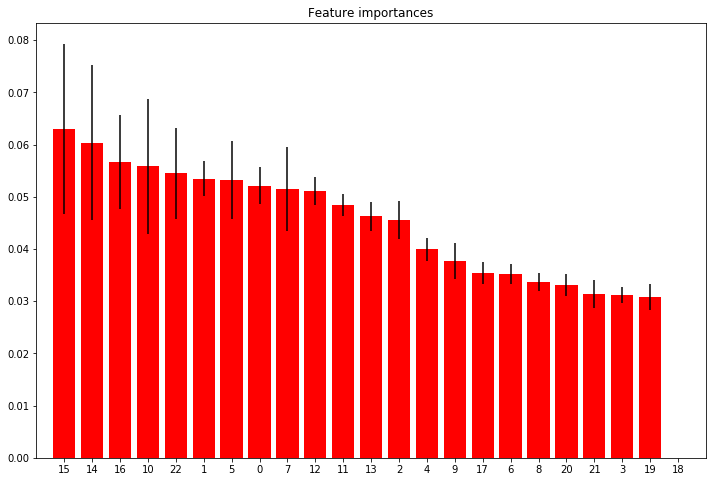

('extratrees', 0.59803695150115477)


In [118]:
# Build a forest and compute the feature importances
X_tr, X_tst, y_tr, y_tst = train_test_split(X_train, y_train, test_size=0.33)
forest = ExtraTreesClassifier(n_estimators=100, random_state=0)
forest.fit(X_tr, y_tr["category"])
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_tr.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(X_tr.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_tr.shape[1]), indices)
plt.xlim([-1, X_tr.shape[1]])
plt.savefig('Feature_importances 23 features.png')
plt.show()
y_pred = forest.predict(X_tst)
print("extratrees",accuracy_score(y_tst["category"], y_pred))

We can determine that feature 18 unique beverages per user is worthless and therefore remove it. We can also remove feature 3 beverages orders  19 beverages reordered versus product reordered ratio as they don't really contribute to the model.

# Correlated Features

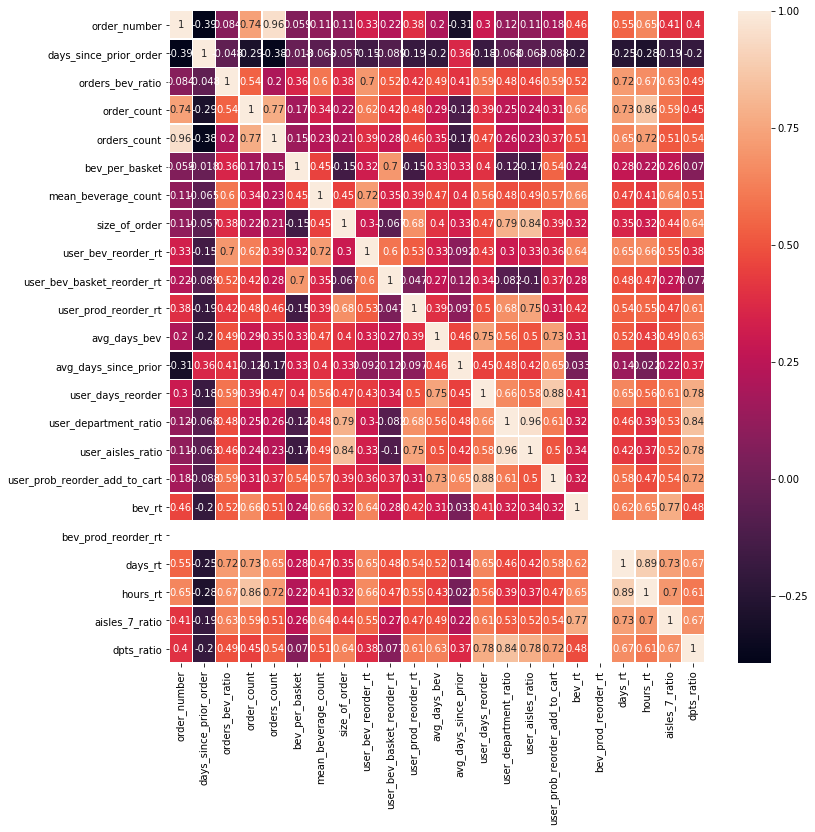

In [119]:
# calculate the correlation matrix
features_corr = X_train.corr()
fig, ax = plt.subplots(figsize=(12,12))         # Sample figsize in inches
# plot the heatmap
sns.heatmap(features_corr, 
        xticklabels=features_corr.columns,
        yticklabels=features_corr.columns,annot=True, linewidths=.5)
plt.savefig("corrrelation.png")


From the correlation matrix we can determine that feature  user average of beverages added early in the cart is highly correlated with feature 5 beverages per basket as well as size of orders feature 7 is highly correlated with  aisles ratio feature 15 and therefore we can remove them since they are also lower in the feature importance rank. Another highly correlated feature is feature 4 orders count to feature 1 order number. Since order number is higher in the feature importance rank we drop feature 4 as well.

In [120]:
X_train = X_train.drop(['order_count', 'bev_rt', 'bev_prod_reorder_rt', 'size_of_order'], axis=1)
X_train.shape

(78725, 19)

In [123]:
X_train = X_train.drop([ 'orders_count', 'user_prob_reorder_add_to_cart'], axis=1)

In [124]:
X_train.shape

(78725, 17)

The features that are finally selected are the following:
- order number
- days since prior order
- orders beverages ratio
- beverages per basket ratio
- mean beverages count per user
- user beverage per basket reorder ratio
- user beverage reorder ratio 
- average days between beverages orders
- average days between orders
- average reorder per days since prior order
- user department ratio
- user aisles ratio
- days ratio
- hours ratio
- aisles of department 7 ratio
- unique departments ratio

We consider 4 different classifiers for the task

- Logistic Regression Classifier
- Xgboost Classifier
- Random Forests Classifier
- Neural Network

## Logistic Regression Classifier

In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

In [126]:
# Train-test evaluate
X_tr, X_tst, y_tr, y_tst = train_test_split(X_train, y_train, test_size=0.33)

X_tr_scaled = preprocessing.scale(X_tr)
X_tst_scaled = preprocessing.scale(X_tst)
logreg = LogisticRegression()
logreg.fit(X_tr_scaled, y_tr["category"])
y_pred = logreg.predict(X_tst_scaled)
print("logreg",accuracy_score(y_tst["category"], y_pred))

('logreg', 0.6157043879907621)


In [ ]:
X_train_scaled = preprocessing.scale(X_train) 
X_test_scaled = preprocessing.scale(X_test)
model_logreg = LogisticRegression()
model_logreg.fit(X_train_scaled, y_train["category"])

In [ ]:
X_test['category'] = logreg.predict(X_test_scaled)
X_test['category'] = np.round(X_test['category']).astype(int)
X_tmp = pd.read_csv("data/X_test.csv")
submission = pd.concat([X_tmp['order_id'], X_test['category']], axis=1)
submission.to_csv("logreg_submission.csv",index=False)

## XgBoost Classifier

In [152]:
import xgboost

In [188]:
# Train-test evaluate
xgb = xgboost.XGBClassifier()

X_tr, X_tst, y_tr, y_tst = train_test_split(X_train, y_train, test_size=0.33)
xgb.fit(X_tr, y_tr["category"])
y_pred_xgb = xgb.predict(X_tst)
print("xgboost",accuracy_score(y_tst["category"], y_pred_xgb))

('xgboost', 0.61620477290223252)


In [ ]:
xgb = xgboost.XGBClassifier()
xgb.fit(X_train, y_train["category"])
X_test['category'] = xgb.predict(X_test)
X_test['category'] = np.round(X_test['category']).astype(int)
X_tmp = pd.read_csv("data/X_test.csv")
submission = pd.concat([X_tmp['order_id'], X_test['category']], axis=1)
submission.to_csv("xgboost_submission.csv",index=False)

In [ ]:
submission_score_xgb = 0.617448652

## Random Forest Classifier

In [179]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [181]:
# Train-test evaluate
X_tr, X_tst, y_tr, y_tst = train_test_split(X_train, y_train, test_size=0.33)

random_forest = RandomForestClassifier(n_estimators=250, n_jobs=8)
random_forest.fit(X_tr, y_tr["category"])
y_pred_random_forest = random_forest.predict(X_tst)
print("random_forest",accuracy_score(y_tst["category"], y_pred_random_forest))

"""
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X_tr, y_tr['category'])
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X_tr, y_tr['category'])

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)
"""

('random_forest', 0.60211701308698995)


'\n# Utility function to report best scores\ndef report(results, n_top=3):\n    for i in range(1, n_top + 1):\n        candidates = np.flatnonzero(results[\'rank_test_score\'] == i)\n        for candidate in candidates:\n            print("Model with rank: {0}".format(i))\n            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(\n                  results[\'mean_test_score\'][candidate],\n                  results[\'std_test_score\'][candidate]))\n            print("Parameters: {0}".format(results[\'params\'][candidate]))\n            print("")\n\n\n# specify parameters and distributions to sample from\nparam_dist = {"max_depth": [3, None],\n              "max_features": sp_randint(1, 11),\n              "min_samples_split": sp_randint(2, 11),\n              "min_samples_leaf": sp_randint(1, 11),\n              "bootstrap": [True, False],\n              "criterion": ["gini", "entropy"]}\n\n# run randomized search\nn_iter_search = 20\nrandom_search = RandomizedSearchCV(

In [182]:
random_forest = RandomForestClassifier(n_estimators=250, n_jobs=8)
random_forest.fit(X_train, y_train["category"])
X_test['category'] = random_forest.predict(X_test)
X_test['category'] = np.round(X_test['category']).astype(int)
X_tmp = pd.read_csv("data/X_test.csv")
submission = pd.concat([X_tmp['order_id'], X_test['category']], axis=1)
submission.to_csv("rand_for_submission.csv",index=False)

# Neural Network

We consider a simple neural network since our number of features is not that high to justify a deep learning approach. The neural network is comprised of the input layer, a middle layer with 17 units (same as the number of features) and tanh as activation and the output layer with a sigmoid function as activation. 

In [183]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [184]:
X_tr, X_tst, y_tr, y_tst = train_test_split(X_train, y_train, test_size=0.33)

In [185]:
model = Sequential()
model.add(Dense(17, input_dim=17, init = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None), activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5000, batch_size=X_train.shape[0])

/home/vasia/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(17, activation="tanh", kernel_initializer=<keras.ini..., input_dim=17)`
  


Epoch 1/5000
78725/78725 [==============================] - 1s 15us/step - loss: 0.7163 - acc: 0.4993
Epoch 2/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.7078 - acc: 0.5007
Epoch 3/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.7032 - acc: 0.5000
Epoch 4/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.7001 - acc: 0.4990
Epoch 5/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6981 - acc: 0.4976
Epoch 6/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6963 - acc: 0.4993
Epoch 7/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6942 - acc: 0.5082
Epoch 8/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6917 - acc: 0.5216
Epoch 9/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6892 - acc: 0.5378
Epoch 10/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6870 - 

Epoch 82/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6574 - acc: 0.6083
Epoch 83/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6573 - acc: 0.6083
Epoch 84/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6572 - acc: 0.6086
Epoch 85/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6572 - acc: 0.6086
Epoch 86/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6571 - acc: 0.6087
Epoch 87/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6571 - acc: 0.6084
Epoch 88/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6570 - acc: 0.6083
Epoch 89/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6569 - acc: 0.6082
Epoch 90/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6569 - acc: 0.6082
Epoch 91/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0

Epoch 162/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6539 - acc: 0.6125
Epoch 163/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6539 - acc: 0.6126
Epoch 164/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6538 - acc: 0.6127
Epoch 165/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6538 - acc: 0.6128
Epoch 166/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6538 - acc: 0.6128
Epoch 167/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6538 - acc: 0.6129
Epoch 168/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6537 - acc: 0.6129
Epoch 169/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6537 - acc: 0.6130
Epoch 170/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6537 - acc: 0.6131
Epoch 171/5000
78725/78725 [==============================] - 0s 1us/step

Epoch 242/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6525 - acc: 0.6142
Epoch 243/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6524 - acc: 0.6141
Epoch 244/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6524 - acc: 0.6142
Epoch 245/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6524 - acc: 0.6143
Epoch 246/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6524 - acc: 0.6143
Epoch 247/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6524 - acc: 0.6144
Epoch 248/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6524 - acc: 0.6143
Epoch 249/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6524 - acc: 0.6143
Epoch 250/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6524 - acc: 0.6144
Epoch 251/5000
78725/78725 [==============================] - 0s 1us/step

Epoch 322/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6517 - acc: 0.6155
Epoch 323/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6517 - acc: 0.6156
Epoch 324/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6517 - acc: 0.6156
Epoch 325/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6517 - acc: 0.6156
Epoch 326/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6517 - acc: 0.6156
Epoch 327/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6517 - acc: 0.6156
Epoch 328/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6517 - acc: 0.6156
Epoch 329/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6517 - acc: 0.6156
Epoch 330/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6517 - acc: 0.6157
Epoch 331/5000
78725/78725 [==============================] - 0s 1us/step

Epoch 402/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6513 - acc: 0.6159
Epoch 403/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6513 - acc: 0.6159
Epoch 404/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6513 - acc: 0.6159
Epoch 405/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6513 - acc: 0.6160
Epoch 406/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6513 - acc: 0.6160
Epoch 407/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6513 - acc: 0.6159
Epoch 408/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6513 - acc: 0.6160
Epoch 409/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6513 - acc: 0.6159
Epoch 410/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6513 - acc: 0.6159
Epoch 411/5000
78725/78725 [==============================] - 0s 0us/step

Epoch 482/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6509 - acc: 0.6163
Epoch 483/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6509 - acc: 0.6164
Epoch 484/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6509 - acc: 0.6165
Epoch 485/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6509 - acc: 0.6165
Epoch 486/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6509 - acc: 0.6164
Epoch 487/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6509 - acc: 0.6165
Epoch 488/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6509 - acc: 0.6166
Epoch 489/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6509 - acc: 0.6166
Epoch 490/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6509 - acc: 0.6167
Epoch 491/5000
78725/78725 [==============================] - 0s 1us/step

Epoch 562/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6507 - acc: 0.6171
Epoch 563/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6507 - acc: 0.6171
Epoch 564/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6507 - acc: 0.6170
Epoch 565/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6507 - acc: 0.6171
Epoch 566/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6507 - acc: 0.6171
Epoch 567/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6506 - acc: 0.6171
Epoch 568/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6506 - acc: 0.6171
Epoch 569/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6506 - acc: 0.6171
Epoch 570/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6506 - acc: 0.6171
Epoch 571/5000
78725/78725 [==============================] - 0s 1us/step

Epoch 642/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6504 - acc: 0.6175
Epoch 643/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6504 - acc: 0.6175
Epoch 644/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6504 - acc: 0.6175
Epoch 645/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6504 - acc: 0.6175
Epoch 646/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6504 - acc: 0.6175
Epoch 647/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6504 - acc: 0.6175
Epoch 648/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6504 - acc: 0.6175
Epoch 649/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6504 - acc: 0.6175
Epoch 650/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6504 - acc: 0.6175
Epoch 651/5000
78725/78725 [==============================] - 0s 1us/step

Epoch 722/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6502 - acc: 0.6178
Epoch 723/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6502 - acc: 0.6178
Epoch 724/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6502 - acc: 0.6179
Epoch 725/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6502 - acc: 0.6179
Epoch 726/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6502 - acc: 0.6179
Epoch 727/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6502 - acc: 0.6179
Epoch 728/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6502 - acc: 0.6179
Epoch 729/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6502 - acc: 0.6179
Epoch 730/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6502 - acc: 0.6179
Epoch 731/5000
78725/78725 [==============================] - 0s 0us/step

Epoch 802/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6501 - acc: 0.6180
Epoch 803/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6501 - acc: 0.6180
Epoch 804/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6501 - acc: 0.6180
Epoch 805/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6501 - acc: 0.6180
Epoch 806/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6501 - acc: 0.6180
Epoch 807/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6501 - acc: 0.6180
Epoch 808/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6501 - acc: 0.6181
Epoch 809/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6501 - acc: 0.6181
Epoch 810/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6501 - acc: 0.6180
Epoch 811/5000
78725/78725 [==============================] - 0s 0us/step

Epoch 882/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6499 - acc: 0.6180
Epoch 883/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6499 - acc: 0.6180
Epoch 884/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6499 - acc: 0.6180
Epoch 885/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6499 - acc: 0.6180
Epoch 886/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6499 - acc: 0.6180
Epoch 887/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6499 - acc: 0.6181
Epoch 888/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6499 - acc: 0.6181
Epoch 889/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6499 - acc: 0.6181
Epoch 890/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6499 - acc: 0.6181
Epoch 891/5000
78725/78725 [==============================] - 0s 1us/step

Epoch 962/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6498 - acc: 0.6178
Epoch 963/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6498 - acc: 0.6181
Epoch 964/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6498 - acc: 0.6182
Epoch 965/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6498 - acc: 0.6179
Epoch 966/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6498 - acc: 0.6182
Epoch 967/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6498 - acc: 0.6179
Epoch 968/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6498 - acc: 0.6179
Epoch 969/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6498 - acc: 0.6182
Epoch 970/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6498 - acc: 0.6179
Epoch 971/5000
78725/78725 [==============================] - 0s 0us/step

78725/78725 [==============================] - 0s 1us/step - loss: 0.6497 - acc: 0.6183
Epoch 1042/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6497 - acc: 0.6183
Epoch 1043/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6497 - acc: 0.6183
Epoch 1044/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6497 - acc: 0.6182
Epoch 1045/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6497 - acc: 0.6183
Epoch 1046/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6497 - acc: 0.6183
Epoch 1047/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6497 - acc: 0.6183
Epoch 1048/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6497 - acc: 0.6182
Epoch 1049/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6497 - acc: 0.6182
Epoch 1050/5000
78725/78725 [==============================] - 0s 0us/step - los

Epoch 1120/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6497 - acc: 0.6173
Epoch 1121/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6497 - acc: 0.6177
Epoch 1122/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6496 - acc: 0.6174
Epoch 1123/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6496 - acc: 0.6179
Epoch 1124/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6496 - acc: 0.6182
Epoch 1125/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6496 - acc: 0.6172
Epoch 1126/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6496 - acc: 0.6181
Epoch 1127/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6496 - acc: 0.6173
Epoch 1128/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6496 - acc: 0.6181
Epoch 1129/5000
78725/78725 [==============================] - 0

Epoch 1199/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6495 - acc: 0.6176
Epoch 1200/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6495 - acc: 0.6176
Epoch 1201/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6495 - acc: 0.6177
Epoch 1202/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6495 - acc: 0.6176
Epoch 1203/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6495 - acc: 0.6177
Epoch 1204/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6495 - acc: 0.6177
Epoch 1205/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6495 - acc: 0.6177
Epoch 1206/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6495 - acc: 0.6177
Epoch 1207/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6495 - acc: 0.6176
Epoch 1208/5000
78725/78725 [==============================] - 0

Epoch 1278/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6494 - acc: 0.6177
Epoch 1279/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6494 - acc: 0.6177
Epoch 1280/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6494 - acc: 0.6177
Epoch 1281/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6494 - acc: 0.6177
Epoch 1282/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6494 - acc: 0.6177
Epoch 1283/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6494 - acc: 0.6177
Epoch 1284/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6494 - acc: 0.6177
Epoch 1285/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6494 - acc: 0.6176
Epoch 1286/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6494 - acc: 0.6176
Epoch 1287/5000
78725/78725 [==============================] - 0

Epoch 1357/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6493 - acc: 0.6177
Epoch 1358/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6493 - acc: 0.6175
Epoch 1359/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6493 - acc: 0.6177
Epoch 1360/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6493 - acc: 0.6177
Epoch 1361/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6493 - acc: 0.6177
Epoch 1362/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6493 - acc: 0.6177
Epoch 1363/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6493 - acc: 0.6176
Epoch 1364/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6493 - acc: 0.6178
Epoch 1365/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6493 - acc: 0.6176
Epoch 1366/5000
78725/78725 [==============================] - 0

Epoch 1436/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6492 - acc: 0.6177
Epoch 1437/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6492 - acc: 0.6177
Epoch 1438/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6492 - acc: 0.6177
Epoch 1439/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6492 - acc: 0.6177
Epoch 1440/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6492 - acc: 0.6177
Epoch 1441/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6492 - acc: 0.6178
Epoch 1442/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6492 - acc: 0.6177
Epoch 1443/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6492 - acc: 0.6177
Epoch 1444/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6492 - acc: 0.6177
Epoch 1445/5000
78725/78725 [==============================] - 0

Epoch 1515/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6491 - acc: 0.6179
Epoch 1516/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6491 - acc: 0.6178
Epoch 1517/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6491 - acc: 0.6178
Epoch 1518/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6491 - acc: 0.6178
Epoch 1519/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6491 - acc: 0.6179
Epoch 1520/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6491 - acc: 0.6178
Epoch 1521/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6491 - acc: 0.6178
Epoch 1522/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6491 - acc: 0.6178
Epoch 1523/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6491 - acc: 0.6178
Epoch 1524/5000
78725/78725 [==============================] - 0

Epoch 1594/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6491 - acc: 0.6180
Epoch 1595/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6491 - acc: 0.6180
Epoch 1596/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6491 - acc: 0.6179
Epoch 1597/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6491 - acc: 0.6180
Epoch 1598/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6491 - acc: 0.6180
Epoch 1599/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6491 - acc: 0.6180
Epoch 1600/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6491 - acc: 0.6180
Epoch 1601/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6491 - acc: 0.6180
Epoch 1602/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6491 - acc: 0.6180
Epoch 1603/5000
78725/78725 [==============================] - 0

Epoch 1673/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6490 - acc: 0.6178
Epoch 1674/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6490 - acc: 0.6186
Epoch 1675/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6490 - acc: 0.6179
Epoch 1676/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6490 - acc: 0.6187
Epoch 1677/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6490 - acc: 0.6183
Epoch 1678/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6490 - acc: 0.6183
Epoch 1679/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6490 - acc: 0.6187
Epoch 1680/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6490 - acc: 0.6178
Epoch 1681/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6490 - acc: 0.6186
Epoch 1682/5000
78725/78725 [==============================] - 0

Epoch 1752/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6489 - acc: 0.6182
Epoch 1753/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6489 - acc: 0.6181
Epoch 1754/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6489 - acc: 0.6182
Epoch 1755/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6489 - acc: 0.6182
Epoch 1756/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6489 - acc: 0.6182
Epoch 1757/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6489 - acc: 0.6182
Epoch 1758/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6489 - acc: 0.6182
Epoch 1759/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6489 - acc: 0.6182
Epoch 1760/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6489 - acc: 0.6182
Epoch 1761/5000
78725/78725 [==============================] - 0

Epoch 1831/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6488 - acc: 0.6183
Epoch 1832/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6488 - acc: 0.6183
Epoch 1833/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6488 - acc: 0.6183
Epoch 1834/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6488 - acc: 0.6183
Epoch 1835/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6488 - acc: 0.6183
Epoch 1836/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6488 - acc: 0.6183
Epoch 1837/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6488 - acc: 0.6183
Epoch 1838/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6488 - acc: 0.6183
Epoch 1839/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6488 - acc: 0.6183
Epoch 1840/5000
78725/78725 [==============================] - 0

Epoch 1910/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6488 - acc: 0.6181
Epoch 1911/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6488 - acc: 0.6187
Epoch 1912/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6488 - acc: 0.6184
Epoch 1913/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6488 - acc: 0.6187
Epoch 1914/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6488 - acc: 0.6185
Epoch 1915/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6488 - acc: 0.6183
Epoch 1916/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6488 - acc: 0.6186
Epoch 1917/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6488 - acc: 0.6184
Epoch 1918/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6488 - acc: 0.6186
Epoch 1919/5000
78725/78725 [==============================] - 0

Epoch 1989/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6487 - acc: 0.6186
Epoch 1990/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6487 - acc: 0.6186
Epoch 1991/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6487 - acc: 0.6186
Epoch 1992/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6487 - acc: 0.6186
Epoch 1993/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6487 - acc: 0.6186
Epoch 1994/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6487 - acc: 0.6186
Epoch 1995/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6487 - acc: 0.6187
Epoch 1996/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6487 - acc: 0.6186
Epoch 1997/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6487 - acc: 0.6187
Epoch 1998/5000
78725/78725 [==============================] - 0

Epoch 2068/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6486 - acc: 0.6187
Epoch 2069/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6486 - acc: 0.6187
Epoch 2070/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6486 - acc: 0.6187
Epoch 2071/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6486 - acc: 0.6187
Epoch 2072/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6486 - acc: 0.6187
Epoch 2073/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6486 - acc: 0.6187
Epoch 2074/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6486 - acc: 0.6187
Epoch 2075/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6486 - acc: 0.6187
Epoch 2076/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6486 - acc: 0.6187
Epoch 2077/5000
78725/78725 [==============================] - 0

Epoch 2147/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6486 - acc: 0.6192
Epoch 2148/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6486 - acc: 0.6190
Epoch 2149/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6486 - acc: 0.6189
Epoch 2150/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6486 - acc: 0.6191
Epoch 2151/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6486 - acc: 0.6187
Epoch 2152/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6486 - acc: 0.6188
Epoch 2153/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6486 - acc: 0.6188
Epoch 2154/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6486 - acc: 0.6188
Epoch 2155/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6486 - acc: 0.6190
Epoch 2156/5000
78725/78725 [==============================] - 0

Epoch 2226/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6485 - acc: 0.6191
Epoch 2227/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6485 - acc: 0.6190
Epoch 2228/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6485 - acc: 0.6191
Epoch 2229/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6485 - acc: 0.6190
Epoch 2230/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6485 - acc: 0.6190
Epoch 2231/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6485 - acc: 0.6190
Epoch 2232/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6485 - acc: 0.6191
Epoch 2233/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6485 - acc: 0.6191
Epoch 2234/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6485 - acc: 0.6191
Epoch 2235/5000
78725/78725 [==============================] - 0

Epoch 2305/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6484 - acc: 0.6189
Epoch 2306/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6484 - acc: 0.6189
Epoch 2307/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6484 - acc: 0.6189
Epoch 2308/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6484 - acc: 0.6189
Epoch 2309/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6484 - acc: 0.6189
Epoch 2310/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6484 - acc: 0.6189
Epoch 2311/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6484 - acc: 0.6189
Epoch 2312/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6484 - acc: 0.6189
Epoch 2313/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6484 - acc: 0.6189
Epoch 2314/5000
78725/78725 [==============================] - 0

Epoch 2384/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6484 - acc: 0.6194
Epoch 2385/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6484 - acc: 0.6189
Epoch 2386/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6484 - acc: 0.6192
Epoch 2387/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6484 - acc: 0.6195
Epoch 2388/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6484 - acc: 0.6190
Epoch 2389/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6484 - acc: 0.6193
Epoch 2390/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6484 - acc: 0.6193
Epoch 2391/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6484 - acc: 0.6190
Epoch 2392/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6484 - acc: 0.6193
Epoch 2393/5000
78725/78725 [==============================] - 0

Epoch 2463/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6483 - acc: 0.6193
Epoch 2464/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6483 - acc: 0.6194
Epoch 2465/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6483 - acc: 0.6194
Epoch 2466/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6483 - acc: 0.6193
Epoch 2467/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6483 - acc: 0.6193
Epoch 2468/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6483 - acc: 0.6193
Epoch 2469/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6483 - acc: 0.6193
Epoch 2470/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6483 - acc: 0.6193
Epoch 2471/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6483 - acc: 0.6193
Epoch 2472/5000
78725/78725 [==============================] - 0

Epoch 2542/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6483 - acc: 0.6194
Epoch 2543/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6483 - acc: 0.6193
Epoch 2544/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6483 - acc: 0.6194
Epoch 2545/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6483 - acc: 0.6194
Epoch 2546/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6483 - acc: 0.6194
Epoch 2547/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6483 - acc: 0.6194
Epoch 2548/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6483 - acc: 0.6194
Epoch 2549/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6483 - acc: 0.6194
Epoch 2550/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6483 - acc: 0.6194
Epoch 2551/5000
78725/78725 [==============================] - 0

Epoch 2621/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6483 - acc: 0.6194
Epoch 2622/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6483 - acc: 0.6196
Epoch 2623/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6483 - acc: 0.6198
Epoch 2624/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6482 - acc: 0.6196
Epoch 2625/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6482 - acc: 0.6199
Epoch 2626/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6483 - acc: 0.6196
Epoch 2627/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6483 - acc: 0.6196
Epoch 2628/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6482 - acc: 0.6194
Epoch 2629/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6482 - acc: 0.6193
Epoch 2630/5000
78725/78725 [==============================] - 0

Epoch 2700/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6482 - acc: 0.6198
Epoch 2701/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6482 - acc: 0.6199
Epoch 2702/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6482 - acc: 0.6198
Epoch 2703/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6482 - acc: 0.6199
Epoch 2704/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6482 - acc: 0.6199
Epoch 2705/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6482 - acc: 0.6199
Epoch 2706/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6482 - acc: 0.6199
Epoch 2707/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6482 - acc: 0.6198
Epoch 2708/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6482 - acc: 0.6198
Epoch 2709/5000
78725/78725 [==============================] - 0

Epoch 2779/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6481 - acc: 0.6197
Epoch 2780/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6481 - acc: 0.6197
Epoch 2781/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6481 - acc: 0.6197
Epoch 2782/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6481 - acc: 0.6197
Epoch 2783/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6481 - acc: 0.6197
Epoch 2784/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6481 - acc: 0.6197
Epoch 2785/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6481 - acc: 0.6197
Epoch 2786/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6481 - acc: 0.6197
Epoch 2787/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6481 - acc: 0.6197
Epoch 2788/5000
78725/78725 [==============================] - 0

Epoch 2858/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6482 - acc: 0.6197
Epoch 2859/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6481 - acc: 0.6197
Epoch 2860/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6481 - acc: 0.6198
Epoch 2861/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6481 - acc: 0.6198
Epoch 2862/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6482 - acc: 0.6197
Epoch 2863/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6481 - acc: 0.6198
Epoch 2864/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6481 - acc: 0.6199
Epoch 2865/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6481 - acc: 0.6202
Epoch 2866/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6481 - acc: 0.6198
Epoch 2867/5000
78725/78725 [==============================] - 0

Epoch 2937/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6480 - acc: 0.6199
Epoch 2938/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6480 - acc: 0.6200
Epoch 2939/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6480 - acc: 0.6200
Epoch 2940/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6480 - acc: 0.6200
Epoch 2941/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6480 - acc: 0.6200
Epoch 2942/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6480 - acc: 0.6200
Epoch 2943/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6480 - acc: 0.6200
Epoch 2944/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6480 - acc: 0.6200
Epoch 2945/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6480 - acc: 0.6200
Epoch 2946/5000
78725/78725 [==============================] - 0

Epoch 3016/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6480 - acc: 0.6199
Epoch 3017/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6480 - acc: 0.6199
Epoch 3018/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6480 - acc: 0.6199
Epoch 3019/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6480 - acc: 0.6199
Epoch 3020/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6480 - acc: 0.6199
Epoch 3021/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6480 - acc: 0.6199
Epoch 3022/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6480 - acc: 0.6199
Epoch 3023/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6480 - acc: 0.6199
Epoch 3024/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6480 - acc: 0.6199
Epoch 3025/5000
78725/78725 [==============================] - 0

Epoch 3095/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6480 - acc: 0.6200
Epoch 3096/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6480 - acc: 0.6199
Epoch 3097/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6480 - acc: 0.6198
Epoch 3098/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6481 - acc: 0.6200
Epoch 3099/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6482 - acc: 0.6197
Epoch 3100/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6483 - acc: 0.6193
Epoch 3101/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6484 - acc: 0.6190
Epoch 3102/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6484 - acc: 0.6190
Epoch 3103/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6482 - acc: 0.6196
Epoch 3104/5000
78725/78725 [==============================] - 0

Epoch 3174/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6479 - acc: 0.6204
Epoch 3175/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6479 - acc: 0.6203
Epoch 3176/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6479 - acc: 0.6202
Epoch 3177/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6479 - acc: 0.6205
Epoch 3178/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6479 - acc: 0.6203
Epoch 3179/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6479 - acc: 0.6204
Epoch 3180/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6479 - acc: 0.6204
Epoch 3181/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6479 - acc: 0.6203
Epoch 3182/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6479 - acc: 0.6204
Epoch 3183/5000
78725/78725 [==============================] - 0

Epoch 3253/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6479 - acc: 0.6205
Epoch 3254/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6479 - acc: 0.6206
Epoch 3255/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6479 - acc: 0.6205
Epoch 3256/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6479 - acc: 0.6205
Epoch 3257/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6479 - acc: 0.6206
Epoch 3258/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6479 - acc: 0.6206
Epoch 3259/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6479 - acc: 0.6206
Epoch 3260/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6479 - acc: 0.6206
Epoch 3261/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6479 - acc: 0.6206
Epoch 3262/5000
78725/78725 [==============================] - 0

Epoch 3332/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6478 - acc: 0.6206
Epoch 3333/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6478 - acc: 0.6206
Epoch 3334/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6478 - acc: 0.6206
Epoch 3335/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6478 - acc: 0.6206
Epoch 3336/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6478 - acc: 0.6206
Epoch 3337/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6478 - acc: 0.6206
Epoch 3338/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6478 - acc: 0.6206
Epoch 3339/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6478 - acc: 0.6206
Epoch 3340/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6478 - acc: 0.6206
Epoch 3341/5000
78725/78725 [==============================] - 0

Epoch 3411/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6479 - acc: 0.6201
Epoch 3412/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6480 - acc: 0.6196
Epoch 3413/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6479 - acc: 0.6200
Epoch 3414/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6478 - acc: 0.6206
Epoch 3415/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6478 - acc: 0.6206
Epoch 3416/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6479 - acc: 0.6201
Epoch 3417/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6479 - acc: 0.6201
Epoch 3418/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6478 - acc: 0.6203
Epoch 3419/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6478 - acc: 0.6207
Epoch 3420/5000
78725/78725 [==============================] - 0

Epoch 3490/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6478 - acc: 0.6208
Epoch 3491/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6478 - acc: 0.6208
Epoch 3492/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6478 - acc: 0.6208
Epoch 3493/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6478 - acc: 0.6208
Epoch 3494/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6478 - acc: 0.6208
Epoch 3495/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6478 - acc: 0.6208
Epoch 3496/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6478 - acc: 0.6208
Epoch 3497/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6478 - acc: 0.6208
Epoch 3498/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6478 - acc: 0.6208
Epoch 3499/5000
78725/78725 [==============================] - 0

Epoch 3569/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6478 - acc: 0.6209
Epoch 3570/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6478 - acc: 0.6209
Epoch 3571/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6478 - acc: 0.6209
Epoch 3572/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6478 - acc: 0.6209
Epoch 3573/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6478 - acc: 0.6209
Epoch 3574/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6478 - acc: 0.6209
Epoch 3575/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6478 - acc: 0.6209
Epoch 3576/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6478 - acc: 0.6209
Epoch 3577/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6478 - acc: 0.6209
Epoch 3578/5000
78725/78725 [==============================] - 0

Epoch 3648/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6206
Epoch 3649/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6206
Epoch 3650/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6206
Epoch 3651/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6206
Epoch 3652/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6206
Epoch 3653/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6206
Epoch 3654/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6206
Epoch 3655/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6206
Epoch 3656/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6477 - acc: 0.6206
Epoch 3657/5000
78725/78725 [==============================] - 0

Epoch 3727/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6205
Epoch 3728/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6206
Epoch 3729/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6477 - acc: 0.6206
Epoch 3730/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6208
Epoch 3731/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6477 - acc: 0.6208
Epoch 3732/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6207
Epoch 3733/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6206
Epoch 3734/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6208
Epoch 3735/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6207
Epoch 3736/5000
78725/78725 [==============================] - 0

Epoch 3806/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6207
Epoch 3807/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6207
Epoch 3808/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6207
Epoch 3809/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6207
Epoch 3810/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6207
Epoch 3811/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6207
Epoch 3812/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6207
Epoch 3813/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6207
Epoch 3814/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6207
Epoch 3815/5000
78725/78725 [==============================] - 0

Epoch 3885/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6207
Epoch 3886/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6207
Epoch 3887/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6207
Epoch 3888/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6207
Epoch 3889/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6207
Epoch 3890/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6207
Epoch 3891/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6207
Epoch 3892/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6207
Epoch 3893/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6207
Epoch 3894/5000
78725/78725 [==============================] - 0

Epoch 3964/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6207
Epoch 3965/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6207
Epoch 3966/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6207
Epoch 3967/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6207
Epoch 3968/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6207
Epoch 3969/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6207
Epoch 3970/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6207
Epoch 3971/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6207
Epoch 3972/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6207
Epoch 3973/5000
78725/78725 [==============================] - 0

Epoch 4043/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6206
Epoch 4044/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6207
Epoch 4045/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6476 - acc: 0.6208
Epoch 4046/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6203
Epoch 4047/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6207
Epoch 4048/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6205
Epoch 4049/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6205
Epoch 4050/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6207
Epoch 4051/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6476 - acc: 0.6205
Epoch 4052/5000
78725/78725 [==============================] - 0

Epoch 4122/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6206
Epoch 4123/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6206
Epoch 4124/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6206
Epoch 4125/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6206
Epoch 4126/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6206
Epoch 4127/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6206
Epoch 4128/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6206
Epoch 4129/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6206
Epoch 4130/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6206
Epoch 4131/5000
78725/78725 [==============================] - 0

Epoch 4201/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6206
Epoch 4202/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6476 - acc: 0.6206
Epoch 4203/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6476 - acc: 0.6206
Epoch 4204/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6476 - acc: 0.6206
Epoch 4205/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6206
Epoch 4206/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6206
Epoch 4207/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6206
Epoch 4208/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6206
Epoch 4209/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6206
Epoch 4210/5000
78725/78725 [==============================] - 0

Epoch 4280/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6202
Epoch 4281/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6477 - acc: 0.6210
Epoch 4282/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6478 - acc: 0.6201
Epoch 4283/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6479 - acc: 0.6209
Epoch 4284/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6480 - acc: 0.6193
Epoch 4285/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6480 - acc: 0.6201
Epoch 4286/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6479 - acc: 0.6197
Epoch 4287/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6477 - acc: 0.6210
Epoch 4288/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6476 - acc: 0.6206
Epoch 4289/5000
78725/78725 [==============================] - 0

Epoch 4359/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6475 - acc: 0.6206
Epoch 4360/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6475 - acc: 0.6206
Epoch 4361/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6205
Epoch 4362/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6206
Epoch 4363/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6205
Epoch 4364/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6206
Epoch 4365/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6206
Epoch 4366/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6205
Epoch 4367/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6207
Epoch 4368/5000
78725/78725 [==============================] - 0

Epoch 4438/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6206
Epoch 4439/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6206
Epoch 4440/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6206
Epoch 4441/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6475 - acc: 0.6206
Epoch 4442/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6475 - acc: 0.6206
Epoch 4443/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6475 - acc: 0.6206
Epoch 4444/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6475 - acc: 0.6206
Epoch 4445/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6206
Epoch 4446/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6205
Epoch 4447/5000
78725/78725 [==============================] - 0

Epoch 4517/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6203
Epoch 4518/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6203
Epoch 4519/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6475 - acc: 0.6203
Epoch 4520/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6475 - acc: 0.6203
Epoch 4521/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6475 - acc: 0.6203
Epoch 4522/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6203
Epoch 4523/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6203
Epoch 4524/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6203
Epoch 4525/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6203
Epoch 4526/5000
78725/78725 [==============================] - 0

Epoch 4596/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6205
Epoch 4597/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6206
Epoch 4598/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6206
Epoch 4599/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6203
Epoch 4600/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6206
Epoch 4601/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6204
Epoch 4602/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6205
Epoch 4603/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6203
Epoch 4604/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6203
Epoch 4605/5000
78725/78725 [==============================] - 0

Epoch 4675/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6201
Epoch 4676/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6201
Epoch 4677/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6201
Epoch 4678/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6201
Epoch 4679/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6201
Epoch 4680/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6475 - acc: 0.6201
Epoch 4681/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6475 - acc: 0.6201
Epoch 4682/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6475 - acc: 0.6201
Epoch 4683/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6201
Epoch 4684/5000
78725/78725 [==============================] - 0

Epoch 4754/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6202
Epoch 4755/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6202
Epoch 4756/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6202
Epoch 4757/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6202
Epoch 4758/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6475 - acc: 0.6202
Epoch 4759/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6475 - acc: 0.6202
Epoch 4760/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6475 - acc: 0.6202
Epoch 4761/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6475 - acc: 0.6202
Epoch 4762/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6475 - acc: 0.6202
Epoch 4763/5000
78725/78725 [==============================] - 0

Epoch 4833/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6474 - acc: 0.6205
Epoch 4834/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6474 - acc: 0.6204
Epoch 4835/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6474 - acc: 0.6205
Epoch 4836/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6474 - acc: 0.6204
Epoch 4837/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6474 - acc: 0.6205
Epoch 4838/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6474 - acc: 0.6204
Epoch 4839/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6474 - acc: 0.6205
Epoch 4840/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6474 - acc: 0.6205
Epoch 4841/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6474 - acc: 0.6205
Epoch 4842/5000
78725/78725 [==============================] - 0

Epoch 4912/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6474 - acc: 0.6207
Epoch 4913/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6474 - acc: 0.6206
Epoch 4914/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6474 - acc: 0.6206
Epoch 4915/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6474 - acc: 0.6208
Epoch 4916/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6474 - acc: 0.6206
Epoch 4917/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6474 - acc: 0.6207
Epoch 4918/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6474 - acc: 0.6205
Epoch 4919/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6474 - acc: 0.6205
Epoch 4920/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6474 - acc: 0.6207
Epoch 4921/5000
78725/78725 [==============================] - 0

Epoch 4991/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6474 - acc: 0.6207
Epoch 4992/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6474 - acc: 0.6207
Epoch 4993/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6474 - acc: 0.6207
Epoch 4994/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6474 - acc: 0.6207
Epoch 4995/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6474 - acc: 0.6207
Epoch 4996/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6474 - acc: 0.6207
Epoch 4997/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6474 - acc: 0.6207
Epoch 4998/5000
78725/78725 [==============================] - 0s 1us/step - loss: 0.6474 - acc: 0.6207
Epoch 4999/5000
78725/78725 [==============================] - 0s 0us/step - loss: 0.6474 - acc: 0.6207
Epoch 5000/5000
78725/78725 [==============================] - 0

In [186]:
scores = model.evaluate(X_tst, y_tst)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

25980/25980 [==============================] - 0s 15us/step

acc: 62.36%


In [187]:
X_test['category'] = model.predict(X_test)
X_test['category'] = np.round(X_test['category']).astype(int)

ValueError: Error when checking : expected dense_1_input to have shape (None, 17) but got array with shape (52484, 18)

In [ ]:
X_tmp = pd.read_csv("data/X_test.csv")

In [ ]:
submission = pd.concat([X_tmp['order_id'], X_test['category']], axis=1)

In [ ]:
submission.to_csv("neuralnet_submission.csv",index=False)

In [ ]:
submission_score_nn = 0.618340827681

The best accuracy score in the submission file was given by the neural network and was 61,83%